<a href="https://colab.research.google.com/github/evanh1393/dsi_capstone/blob/main/03_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import sample

import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Concatenate, Dense, Dropout, Lambda, Activation, Add, Average, Flatten, Multiply
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

In [13]:
# Tensorboard
%load_ext tensorboard

In [14]:
import tensorboard
tensorboard.__version__

'2.6.0'

# Mounting Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Dataframe

In [16]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/one-m-capstone/data/main/'

In [17]:
df = pd.read_csv(DATA_PATH + 'combined.csv')

In [18]:
movies = pd.read_csv(DATA_PATH + 'processed_movies.csv')

# Content Based Filtering Engines

Content Filtering engines use item features in order to recommend items to a user. For our dataset we are going to use the genres feature of our movies in order to recommend other similar genres to users. One of the ways to achieve this is by simply grouping like products together. One way of doing this is to simply group. Another way is to group based off a mathematic distance. For our genres we are computing the cosine similarity between genres, which is a crude form of nlp.

While this is not really necessary for our dataset, since all of our genres are effecitvely sorted, the same process used on genres here could be used in collaborative filtering as well. Insetead of turning the genres into vectors, you essentially create vectors based of user scores where every score from every user is compared to every score from every other user. These types of recommendation engines are known as **memory-based** models.

The issue with using **memory-base** models is their load. For these to work often times large amounts of data have to be stored in memory. There are workarounds such as using generators, or parallel execution, but for the most part these methods tend to beocome more dubious as the size of your data increases.


In [19]:
# Create a tf-idf matrix of genres found
tf_vec = TfidfVectorizer()
tfidf_matrix = tf_vec.fit_transform(movies['genres'])

# Cosine similarity is done implicitly by the l2 normalization applied from the 
# tf-idf matrix, we can just use linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [20]:
def genre_recommendations(title):
  # Looks at a title and returns the top 5 most similar titles
  titles = movies['title']
  indices = pd.Series(movies.index, index=movies['title'])
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  top_scores = sim_scores[1:6]
  movie_indices = [i[0] for i in top_scores]
  return titles.iloc[movie_indices]

In [21]:
genre_recommendations('Heaven & Earth (1993)')

461           Heaven & Earth (1993)
1204       Full Metal Jacket (1987)
1214    Boat, The (Das Boot) (1981)
1222                   Glory (1989)
1545               G.I. Jane (1997)
Name: title, dtype: object

### Implementation

When we are using this algorithm inside the web app, we will filter movie titles based on movies that have already been seen as to not recommend movies that have already been viewed by the user.

# Collaborative Modeling


In [22]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie']].values
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [23]:
n_users

6041

In [24]:
n_movies

3883

In [25]:
f_dim = 10 # this is the n-dimension of our embedding layers it is a hyper param

def Recommender(n_users, n_movies, n_factors):
    
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal', name='user_embedding',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,), name='user_reshape')(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal', name='movie_embedding',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,), name='movie_reshape')(m)


    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    

    return model

In [26]:
model = Recommender(n_users, n_movies, f_dim)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60410       input_1[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 10)        38830       input_2[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
tf.keras.models.save_model(
    model, DATA_PATH + 'implemented_model.keras'
)

In [28]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

early_stop = EarlyStopping(patience=2)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop,tensorboard_callback]
)

Epoch 1/5
6253/6253 [==============================] - 12s 2ms/step - loss: 4.7138 - val_loss: 1.1266
Epoch 2/5
6253/6253 [==============================] - 11s 2ms/step - loss: 0.9663 - val_loss: 0.9122
Epoch 3/5
6253/6253 [==============================] - 11s 2ms/step - loss: 0.8954 - val_loss: 0.8959
Epoch 4/5
6253/6253 [==============================] - 11s 2ms/step - loss: 0.8860 - val_loss: 0.8902
Epoch 5/5
6253/6253 [==============================] - 11s 2ms/step - loss: 0.8800 - val_loss: 0.8868


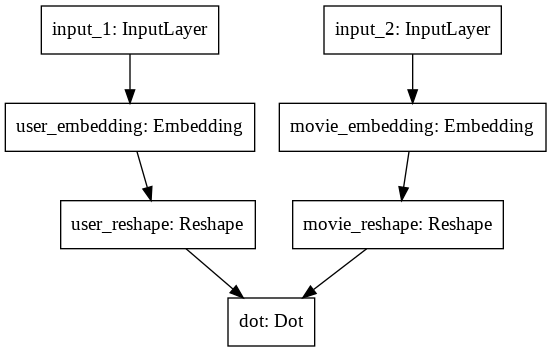

In [29]:
plot_model(model)

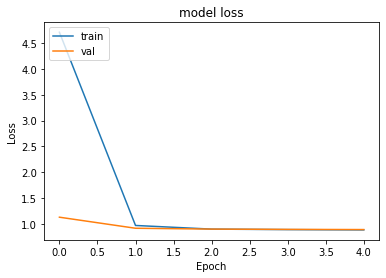

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Improved Model

The improved model is the result of adding more features onto our user and item vectors. Instead of simply embedding and flattening the ids, we embed and flatten other data that is related to the concept of our user and item, in addition we add a bias layer to the input which is added to the final large vector, and then sent to 2-layer neural network. The final output is sent to a sigmoid function, of which the that output is multiplied by 5 so we are better within the actual range of our output. The ultimate goal here was to create a model that learned relationships better.

The next improvement would probably be to implement some Convolutional Layer that could better select the important features from our embeddings. In doing this we can better regularize our input features, and this would even be more of a "matrix-decomp" model.

In [31]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3], X_test[:, 4]]

In [32]:
f_dim = 50
def Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_factors):
    # USER
    # user
    user = Input(shape=(1,), name='user_input')
    uv = Embedding(n_users, n_factors, name='user_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    uv = Flatten(name='user_vector')(uv)

    # job
    job = Input(shape=(1,), name='job_input')
    jv = Embedding(n_jobs, n_factors, name='job_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
    jv = Flatten(name='job_vector')(jv)

    # age
    age = Input(shape=(1,), name='age_input')
    a = Embedding(n_ages, n_factors, name='age_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    av = Flatten(name='age_vector')(a)

    # ITEMS
    # movies
    movie = Input(shape=(1,), name='movie_input')
    m = Embedding(n_movies, n_factors, name='movie_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten(name='movie_vector')(m)
    # genres
    genre = Input(shape=(1,), name='genre_input')
    g = Embedding(n_genres, n_factors, name='genre_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)
    g = Flatten(name='genre_vector')(g)

    # user vector creation
    u = Concatenate(name='user_concat')([uv,jv,av])
    u = Dropout(.2)(u)

    # items vector creation
    i = Concatenate(name='item_concat')([m,g])
    i = Dropout(.2)(i)

    # bias layers
    uvb = Embedding(n_users, 1, name='user_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    jb = Embedding(n_jobs, 1, name='job_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
                  
    ab = Embedding(n_ages, 1, name='age_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    mb = Embedding(n_movies, 1, name='movie_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie) 
    gb = Embedding(n_movies, 1, name='genre_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)

    # bias vectors
    ub = Multiply(name='user_bias_mult')([uvb,jb,ab])
    ib = Multiply(name='item_bias_mult')([mb,gb])
    
    # ANN
    x = Concatenate()([u, i])
    x = Dropout(.2)(x)
    x = Add()([x, ub, ib])
    x = Dense(1024, activation='relu', name='hidden_layer_1')(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation='relu', name='hidden_layer_2')(x)
    x = Dropout(.5)(x)
    x = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x)

    model = Model(inputs=[user, movie, genre, job, age], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    

    return model

model = Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, f_dim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
job_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
age_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [33]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=.005, patience=3)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop, tensorboard_callback]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6253/6253 [==============================] - 83s 13ms/step - loss: 0.8945 - val_loss: 0.8255
Epoch 2/20
6253/6253 [==============================] - 84s 13ms/step - loss: 0.8314 - val_loss: 0.8082
Epoch 3/20
6253/6253 [==============================] - 84s 13ms/step - loss: 0.8104 - val_loss: 0.7854
Epoch 4/20
6253/6253 [==============================] - 86s 14ms/step - loss: 0.7923 - val_loss: 0.7794
Epoch 5/20
6253/6253 [==============================] - 84s 13ms/step - loss: 0.7814 - val_loss: 0.7734
Epoch 6/20
6253/6253 [==============================] - 88s 14ms/step - loss: 0.7733 - val_loss: 0.7649
Epoch 7/20
6253/6253 [==============================] - 87s 14ms/step - loss: 0.7664 - val_loss: 0.7654
Epoch 8/20
6253/6253 [==============================] - 89s 14ms/step - loss: 0.7614 - val_loss: 0.7596
Epoch 9/20
6253/6253 [==============================] - 86s 14ms/step - loss: 0.7562 - val_loss: 0.7597
Epoch 10/20
6253/6253 [==============================] - 85s 14ms/step - lo

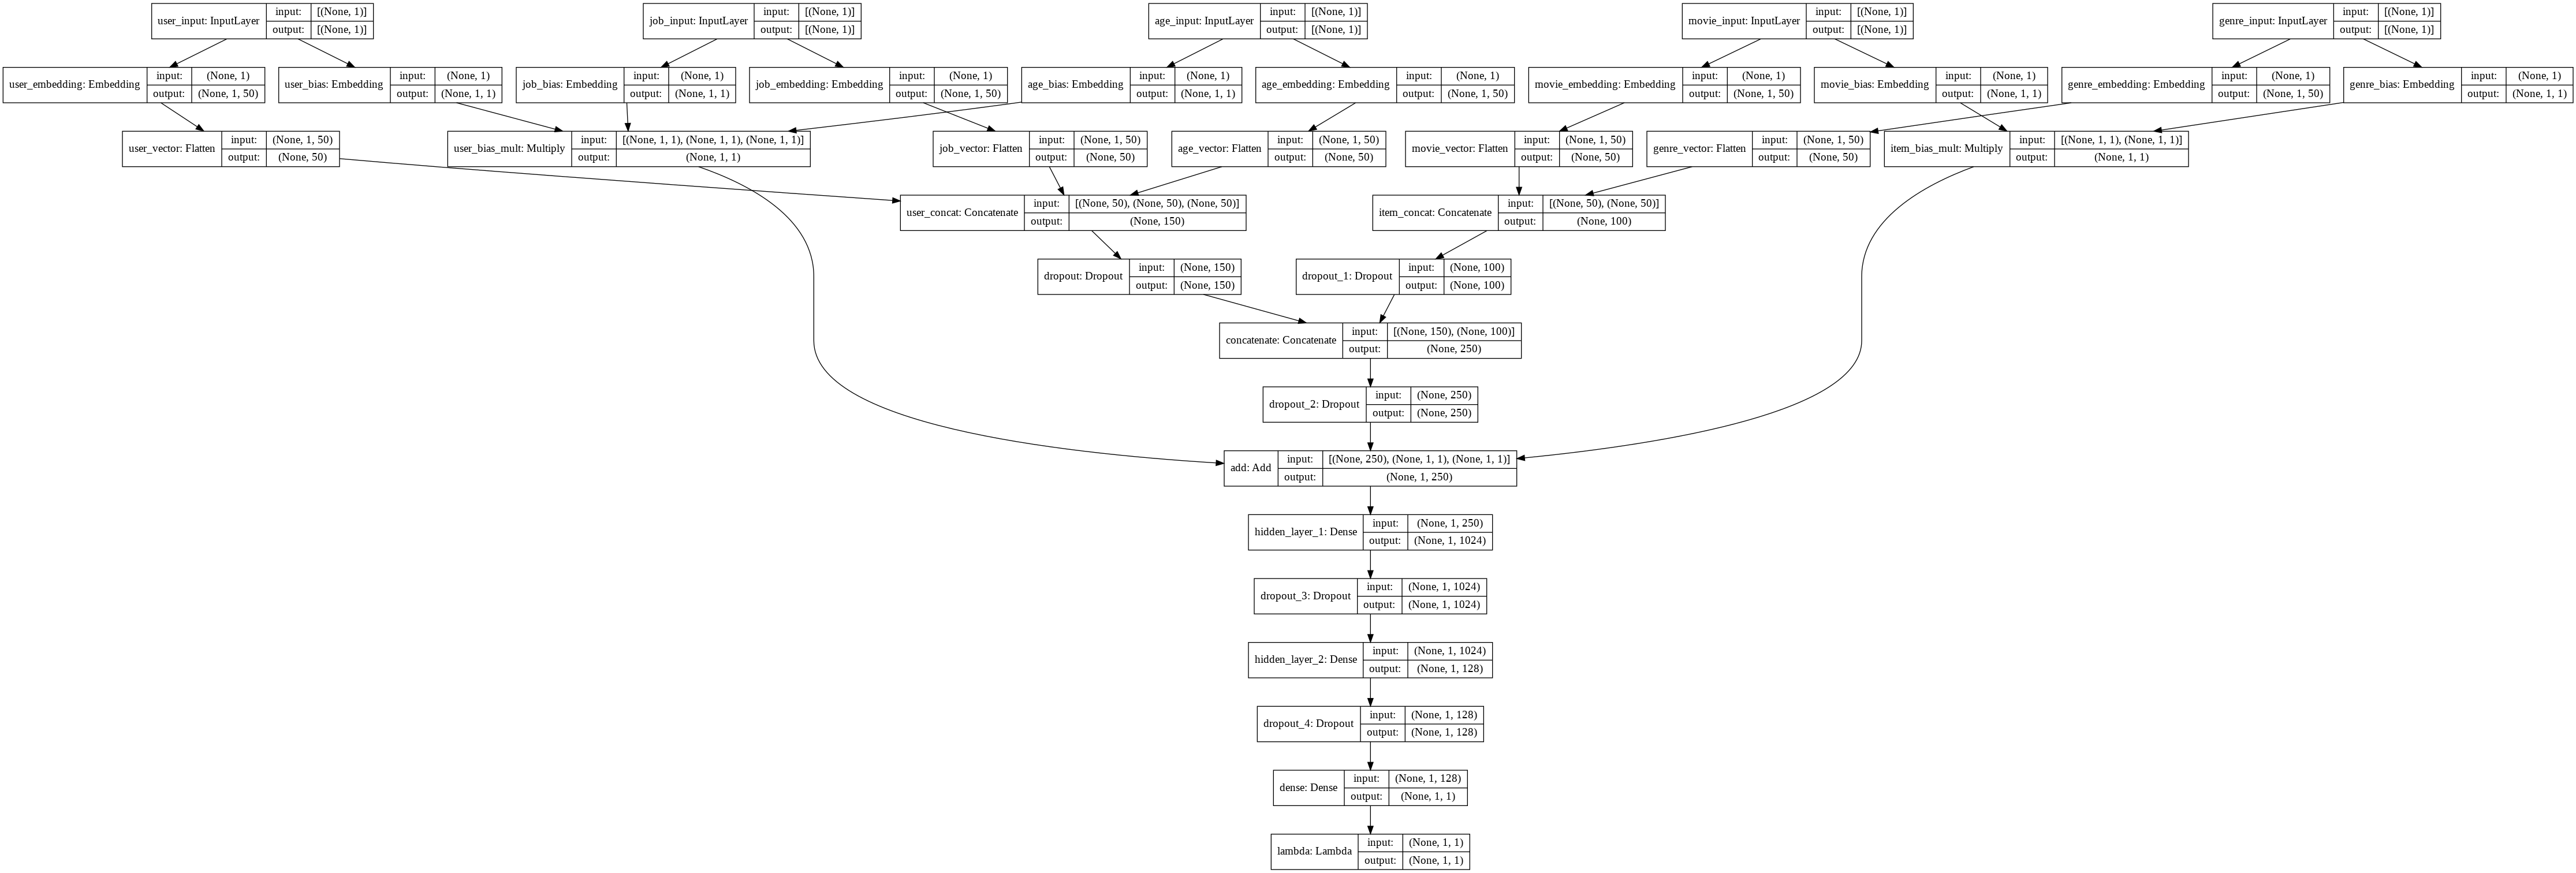

In [34]:
plot_model(model, show_shapes=True)

In [35]:
tf.keras.models.save_model(
    model, DATA_PATH + 'official_model.keras'
)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


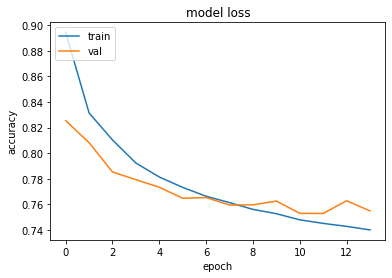

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()